In [1]:
# Core imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import time
import csv
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import sys

# Add parent folder to sys.path for module imports
BASE_DIR = Path("..").resolve()
sys.path.append(str(BASE_DIR))

# Import our MoE model from optimization/moe.py
from optimization.moe import FFN_MoE
# Reproducibility
torch.manual_seed(0)

device = "cpu"  # keep consistent for latency comparison


In [2]:
# Project paths
DATA_DIR = Path("../data")
EXP_DIR = Path("../experiments")
MODEL_DIR = Path("../models")

EXP_DIR.mkdir(exist_ok=True)
MODEL_DIR.mkdir(exist_ok=True)

# MNIST preprocessing
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# Load dataset
train_set = datasets.MNIST(DATA_DIR, train=True, download=False, transform=transform)
test_set  = datasets.MNIST(DATA_DIR, train=False, download=False, transform=transform)

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_set, batch_size=64, shuffle=False)


In [3]:


# Load pretrained MoE teacher
teacher = FFN_MoE().to(device)
teacher.load_state_dict(torch.load(MODEL_DIR / "sparse_moe_mnist.pth", map_location=device))
teacher.eval()

print("Sparse MoE teacher loaded")


Sparse MoE teacher loaded


In [4]:
# Smaller student model (distilled)
class StudentFFN(nn.Module):
    """
    Lightweight student to absorb MoE knowledge
    """
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

student = StudentFFN().to(device)


In [ ]:
# Knowledge Distillation setup
# Student tries to match teacher probability distribution
ce_loss = nn.CrossEntropyLoss()
kd_loss = nn.KLDivLoss(reduction="batchmean")

# Softens probabilities, Reveals teacher confidence patterns
T = 4.0      # temperature
alpha = 0.7  # KD vs CE balance

optimizer = torch.optim.Adam(student.parameters(), lr=1e-3)


In [ ]:
EPOCHS = 5
history = {
    "student_loss": [],
    "student_acc": []
}

for epoch in range(EPOCHS):
    student.train()
    total_loss, total_acc = 0.0, 0.0

    for x, y in train_loader:
        x, y = x.to(device), y.to(device)

        # ===== Teacher forward (NO grad, eval mode) =====
        with torch.no_grad():
            teacher_logits, _, _ = teacher(x)
            teacher_probs = F.softmax(teacher_logits / T, dim=1)

        # ===== Student forward =====
        # Student tries to imitate teacher behavior
        student_logits = student(x)
        student_log_probs = F.log_softmax(student_logits / T, dim=1)

        # ===== Knowledge Distillation loss =====
        loss_kd = kd_loss(student_log_probs, teacher_probs) * (T * T)
        loss_ce = ce_loss(student_logits, y)

        loss = alpha * loss_kd + (1 - alpha) * loss_ce

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_acc += (student_logits.argmax(1) == y).float().mean().item()

    # ===== Epoch averages =====
    avg_loss = total_loss / len(train_loader)
    avg_acc = total_acc / len(train_loader)

    history["student_loss"].append(avg_loss)
    history["student_acc"].append(avg_acc)

    print(
        f"Epoch {epoch+1}: "
        f"Loss={avg_loss:.4f}, "
        f"Acc={avg_acc:.4f}"
    )


Epoch 1: Loss=0.1194, Acc=0.9838
Epoch 2: Loss=0.1095, Acc=0.9843
Epoch 3: Loss=0.1012, Acc=0.9851
Epoch 4: Loss=0.0955, Acc=0.9858
Epoch 5: Loss=0.0903, Acc=0.9865


In [13]:
def evaluate_student(model, loader):
    model.eval()
    correct = 0
    start = time.time()

    with torch.no_grad():
        for x, y in loader:
            x, y = x.to(device), y.to(device)
            logits = model(x)
            correct += (logits.argmax(1) == y).sum().item()

    latency = (time.time() - start) / len(loader)
    accuracy = correct / len(loader.dataset)
    return accuracy, latency


In [14]:
test_acc, test_latency = evaluate_student(student, test_loader)
train_acc = history["student_acc"][-1]
train_loss = history["student_loss"][-1]

# Parameter-based size (FP32)
num_params = sum(p.numel() for p in student.parameters())
size_MB = num_params * 4 / (1024 ** 2)

print(f"Student Test Acc : {test_acc:.4f}")
print(f"Student Size     : {size_MB:.4f} MB")
print(f"Latency (batch)  : {test_latency:.6f}s")


Student Test Acc : 0.9747
Student Size     : 0.3882 MB
Latency (batch)  : 0.023592s


In [15]:
RESULTS_CSV = EXP_DIR / "results.csv"
file_exists = RESULTS_CSV.exists()

with open(RESULTS_CSV, "a", newline="") as f:
    writer = csv.writer(f)
    if not file_exists:
        writer.writerow(["model", "test_accuracy", "train_accuracy", "Loss", "Size(M)", "Latency(s)"])

    writer.writerow([
        "KD_FFN_Student",
        float(test_acc),
        float(train_acc),
        float(train_loss),
        float(size_MB),
        float(test_latency)
    ])

print("KD metrics saved")


KD metrics saved


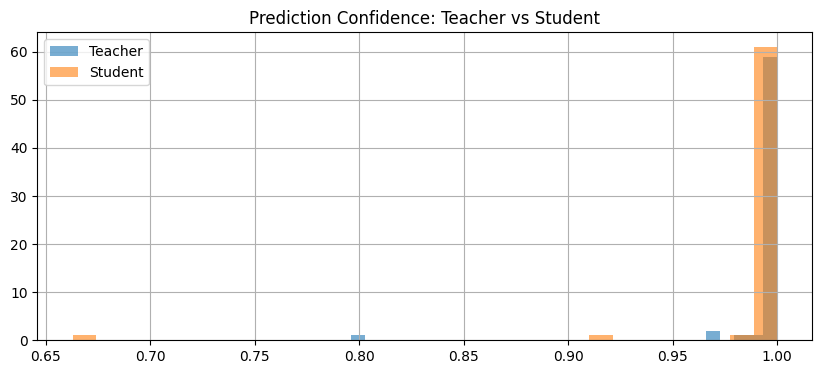

In [18]:
teacher.eval()
student.eval()

x, _ = next(iter(test_loader))
x = x.to(device)

with torch.no_grad():
    t_logits, _, _ = teacher(x)
    s_logits = student(x)

plt.figure(figsize=(10,4))
plt.hist(t_logits.softmax(1).max(1).values.cpu(), bins=30, alpha=0.6, label="Teacher")
plt.hist(s_logits.softmax(1).max(1).values.cpu(), bins=30, alpha=0.6, label="Student")
plt.title("Prediction Confidence: Teacher vs Student")
plt.legend()
plt.grid()
plt.show()
